In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Download the EuroSAT_RGB dataset and create data loaders
data_dir = 'C:/Users/krish/Downloads/STA380-master/data/EuroSAT_RGB'

transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Create an ImageFolder dataset
dataset = ImageFolder(data_dir, transform = transform)

# Split the dataset into train and test sets
train_ratio = 0.8  # You can adjust the train-test split ratio
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

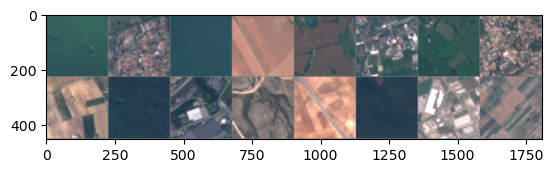

Labels: 9 7 9 0 5 4 5 7 6 1 4 2 3 1 4 6


In [7]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))

In [3]:
# Let's define a simple CNN to classify digits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1548800, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1548800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

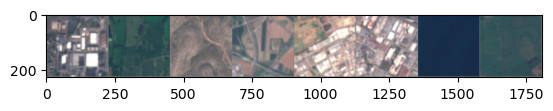

Predicted: Industrial Forest Industrial Industrial Industrial Industrial Forest Forest


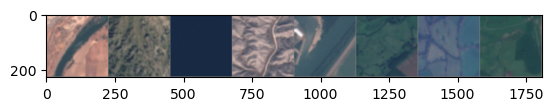

Predicted: AnnualCrop PermanentCrop River Industrial Residential River Industrial River


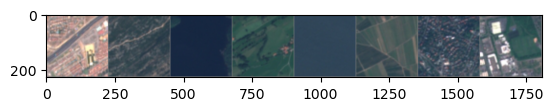

Predicted: PermanentCrop Residential River River River River Residential Industrial


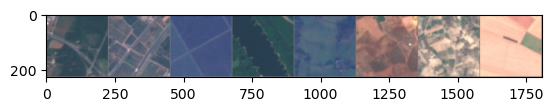

Predicted: Residential Residential River River River AnnualCrop AnnualCrop AnnualCrop


In [8]:
# Number of training epochs
num_epochs = 5

testiter = iter(test_loader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = testiter.__next__()
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                # Map predicted indices to class labels
                predicted_labels = [dataset.classes[idx] for idx in predicted]
                
                print('Predicted:', ' '.join(predicted_labels))
                
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')

In [ ]:
# Calculate accuracy score and confusion matrix after the training loop
net.eval()  # Set the model to evaluation mode

all_predictions = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        _, predicted_indices = torch.max(outputs, 1)
        
        all_predictions.extend(predicted_indices.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predicted indices to class labels
predicted_labels_1 = [dataset.classes[idx] for idx in all_predictions]
true_labels = [dataset.classes[label] for label in all_labels]

# Calculate accuracy score
test_accuracy = accuracy_score(true_labels, predicted_labels_1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_1, labels=dataset.classes)

# Print accuracy score
print(f"Test Accuracy: {test_accuracy:.2f}")

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

KeyboardInterrupt: 

In [ ]:
# Plot confusion matrix using seaborn and matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()